##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 8개 학교

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Eight_Schools"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/probability/examples/Eight_Schools.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/probability/examples/Eight_Schools.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/probability/examples/Eight_Schools.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

8개 학교 문제(The eight schools problem)([Rubin 1981](https://www.jstor.org/stable/1164617))는 8개 학교에서 동시에 수행되는 SAT 코칭 프로그램의 효과를 고려하는 문제입니다. 이는 교환 가능한 그룹 간에 정보를 공유하기 위한 계층적 모델링의 유용성을 보여주는 고전적인 문제([Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), [Stan](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started))가 되었습니다.

아래 구현은 Edward 1.0 [튜토리얼](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb)을 수정한 것입니다.

# 가져오기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import warnings

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

# 데이터

베이지안 데이터 분석, 5.5 섹션(Gelman 외, 2013)은 다음과 같습니다.

> *각 8개 고등학교에서 SAT-V(Scholastic Aptitude Test-Verbal)에 대한 특수 코칭 프로그램의 효과를 분석하기 위해 교육 테스트 서비스를 위한 연구가 수행되었습니다. 각 연구의 결과 변수는 SAT-V의 특별 관리 점수로, 교육 시험 서비스에서 관리하고 대학의 입학 결정을 돕는 데 사용되는 표준화된 객관식 시험입니다. 점수는 200에서 800까지 다양하며 평균은 약 500, 표준 편차는 약 100입니다. SAT 시험은 특히 시험 성적 향상을 위한 단기적인 노력에 저항하도록 설계되었습니다. 대신 이들 시험은 수년간의 교육을 통해 습득한 지식과 개발된 능력을 반영하도록 설계되었습니다. 그런데도 이 연구에 참여한 각각의 8개 학교는 단기 코칭 프로그램이 SAT 점수를 높이는 데 매우 성공적이라고 생각했습니다. 또한 8개 프로그램 중 어떤 것이 다른 프로그램보다 더 효과적이거나 어떤 프로그램이 다른 프로그램보다 효과가 더 유사하다고 믿을만한 선행 사유가 없었습니다.*

각 8개 학교($J = 8$)에 대해 추정된 처치 효과 $y_j$와 효과 추정치 $\sigma_j$의 표준 오차가 있습니다. 이 연구에서 처치 효과는 PSAT-M 및 PSAT-V 점수를 통제 변수로 사용하여 처치 집단에 대한 선형 회귀를 통해 얻었습니다. 어느 학교가 서로 어느 정도 유사하거나, 어떤 코칭 프로그램이 더 효과적일 것이라는 기존 믿음이 없었으므로 처치 효과를 [교환 가능한 것](https://en.wikipedia.org/wiki/Exchangeable_random_variables)으로 간주할 수 있습니다.

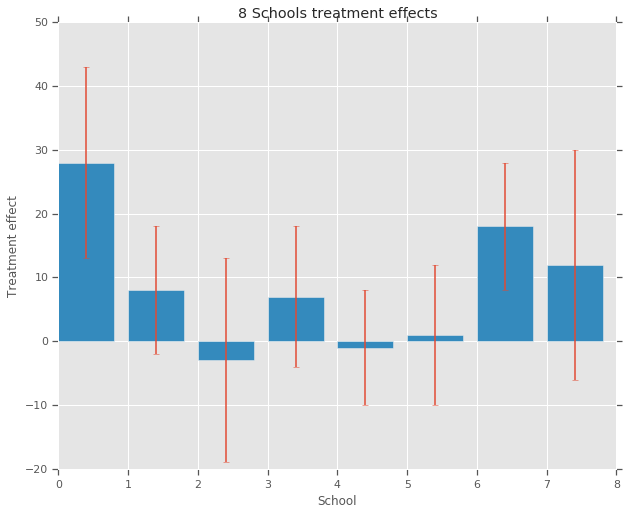

In [ ]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

# 모델

데이터를 캡처하기 위해 계층적 정규 모델을 사용합니다. 다음의 생성 과정을 따릅니다.

$$ \begin{align*} \mu &\sim \text{Normal}(\text{loc}{=}0,\ \text{scale}{=}10) \ \log\tau &\sim \text{Normal}(\text{loc}{=}5,\ \text{scale}{=}1) \ \text{for } & i=1\ldots 8:\ & \theta_i \sim \text{Normal}\left(\text{loc}{=}\mu,\ \text{scale}{=}\tau \right) \ & y_i \sim \text{Normal}\left(\text{loc}{=}\theta_i,\ \text{scale}{=}\sigma_i \right) \end{align*} $$

여기서 $\mu$는 이전 평균 처치 효과를 나타내며 $\tau$는 학교 간의 분산을 제어합니다. $y_i$ 및 $\sigma_i$가 관찰됩니다. $\tau \rightarrow \infty$로 모델은 풀링 없음 모델에 접근합니다. 즉, 각 학교 처치 효과 추정치가 더 독립적일 수 있습니다. $\tau \rightarrow 0$로 모델은 완전 풀링 모델에 접근합니다. 즉, 모든 학교 처치 효과가 그룹 평균 $\mu$에 더 가깝습니다. 표준 편차를 양수로 제한하기 위해 로그 정규 분포에서 $\tau$를 그립니다(정규 분포에서 $\log(\tau)$를 그리는 것과 동일함).

[발산(divergence)을 사용한 바이어스 추론 진단](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html)에 따라 위의 모델을 동등한 비 중심 모델로 변환합니다.

$$ \begin{align*} \mu &\sim \text{Normal}(\text{loc}{=}0,\ \text{scale}{=}10) \ \log\tau &\sim \text{Normal}(\text{loc}{=}5,\ \text{scale}{=}1) \ \text{for } & i=1\ldots 8:\ & \theta_i' \sim \text{Normal}\left(\text{loc}{=}0,\ \text{scale}{=}1 \right) \ & \theta_i = \mu + \tau \theta_i' \ & y_i \sim \text{Normal}\left(\text{loc}{=}\theta_i,\ \text{scale}{=}\sigma_i \right) \end{align*} $$

이 모델을 [JointDistributionSequential](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionSequential) 인스턴스로 실체화합니다.

In [ ]:
model = tfd.JointDistributionSequential([
  tfd.Normal(loc=0., scale=10., name="avg_effect"),  # `mu` above
  tfd.Normal(loc=5., scale=1., name="avg_stddev"),  # `log(tau)` above
  tfd.Independent(tfd.Normal(loc=tf.zeros(num_schools),
                             scale=tf.ones(num_schools),
                             name="school_effects_standard"),  # `theta_prime` 
                  reinterpreted_batch_ndims=1),
  lambda school_effects_standard, avg_stddev, avg_effect: (
      tfd.Independent(tfd.Normal(loc=(avg_effect[..., tf.newaxis] +
                                      tf.exp(avg_stddev[..., tf.newaxis]) *
                                      school_effects_standard),  # `theta` above
                                 scale=treatment_stddevs),
                      name="treatment_effects",  # `y` above
                      reinterpreted_batch_ndims=1))
])

def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
  """Unnormalized target density as a function of states."""
  return model.log_prob((
      avg_effect, avg_stddev, school_effects_standard, treatment_effects))

# 베이지안 추론

주어진 데이터에서 해밀턴 몬테카를로(HMC)를 수행하여 모델의 매개변수에 대한 사후 확률 분포를 계산합니다.

In [ ]:
num_results = 5000
num_burnin_steps = 3000

# Improve performance by tracing the sampler using `tf.function`
# and compiling it using XLA.
@tf.function(autograph=False, experimental_compile=True)
def do_sampling():
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.zeros([], name='init_avg_effect'),
          tf.zeros([], name='init_avg_stddev'),
          tf.ones([num_schools], name='init_school_effects_standard'),
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.4,
          num_leapfrog_steps=3))

states, kernel_results = do_sampling()

avg_effect, avg_stddev, school_effects_standard = states

school_effects_samples = (
    avg_effect[:, np.newaxis] +
    np.exp(avg_stddev)[:, np.newaxis] * school_effects_standard)

num_accepted = np.sum(kernel_results.is_accepted)
print('Acceptance rate: {}'.format(num_accepted / num_results))

Acceptance rate: 0.5974


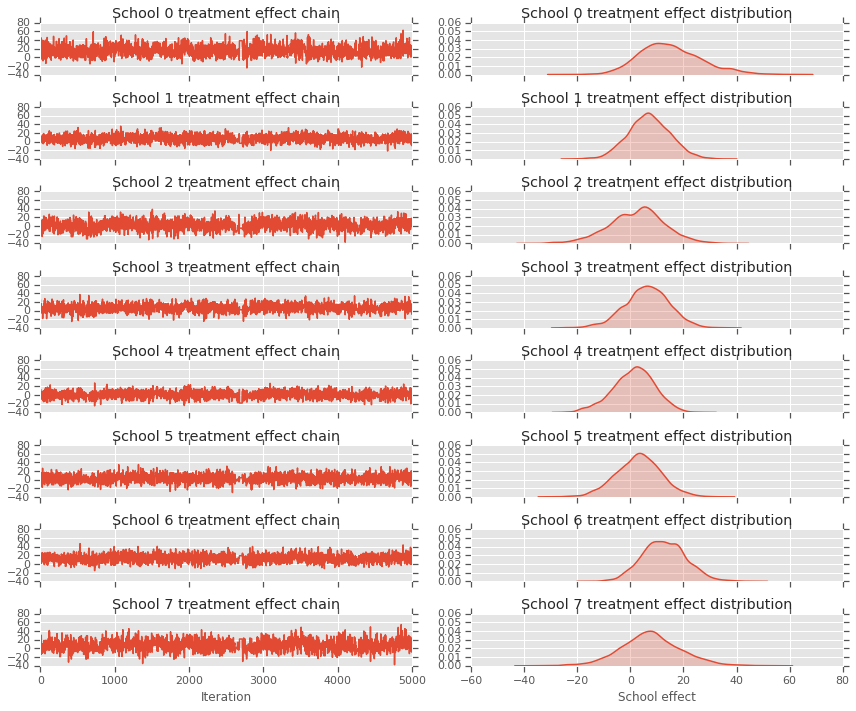

In [ ]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i].numpy())
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i].numpy(), ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [ ]:
print("E[avg_effect] = {}".format(np.mean(avg_effect)))
print("E[avg_stddev] = {}".format(np.mean(avg_stddev)))
print("E[school_effects_standard] =")
print(np.mean(school_effects_standard[:, ]))
print("E[school_effects] =")
print(np.mean(school_effects_samples[:, ], axis=0))

E[avg_effect] = 5.57183933258
E[avg_stddev] = 2.47738981247
E[school_effects_standard] =
0.08509017
E[school_effects] =
[15.0051     7.103311   2.4552586  6.2744603  1.3364682  3.1125953
 12.762501   7.743602 ]


In [ ]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(num_schools)
])

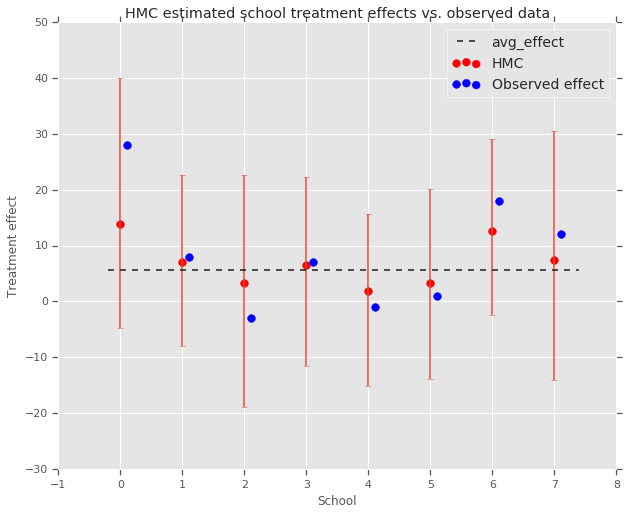

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(num_schools)) + 0.1, treatment_effects, color='blue', s=60)

plt.plot([-0.2, 7.4], [np.mean(avg_effect),
                       np.mean(avg_effect)], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('avg_effect', 'HMC', 'Observed effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()

위의 `avg_effect` 그룹에 대한 축소를 관찰할 수 있습니다.

In [ ]:
print("Inferred posterior mean: {0:.2f}".format(
    np.mean(school_effects_samples[:,])))
print("Inferred posterior mean se: {0:.2f}".format(
    np.std(school_effects_samples[:,])))

Inferred posterior mean: 6.97
Inferred posterior mean se: 10.41


# 비평

사후 예측 분포, 즉 관측된 데이터 $y$를 고려하여 새 데이터 $y^*$의 모델을 구합니다.

$$ p(y^*|y) \propto \int_\theta p(y^* | \theta)p(\theta |y)d\theta$$

모델의 확률 변수값을 재정의하여 사후 분포의 평균으로 설정하고, 해당 모델에서 샘플링하여 새 데이터 $y^*$를 생성합니다.

In [ ]:
sample_shape = [5000]

_, _, _, predictive_treatment_effects = model.sample(
    value=(tf.broadcast_to(np.mean(avg_effect, 0), sample_shape),
           tf.broadcast_to(np.mean(avg_stddev, 0), sample_shape),
           tf.broadcast_to(np.mean(school_effects_standard, 0),
                           sample_shape + [num_schools]),
           None))

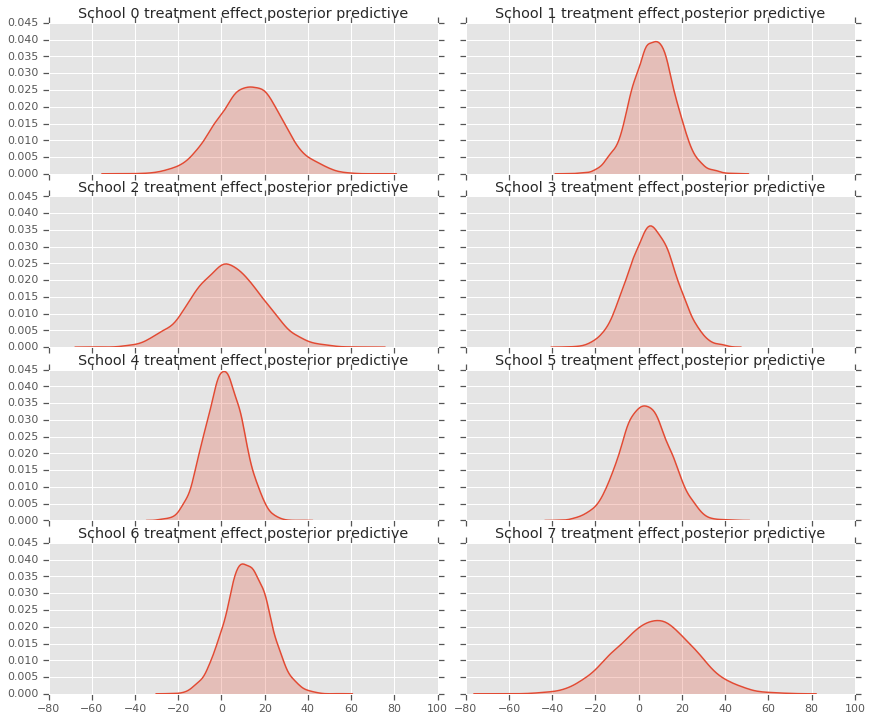

In [ ]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(predictive_treatment_effects[:, 2*i].numpy(),
              ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i))
  sns.kdeplot(predictive_treatment_effects[:, 2*i + 1].numpy(),
              ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i + 1))
plt.show()

In [ ]:
# The mean predicted treatment effects for each of the eight schools.
prediction = np.mean(predictive_treatment_effects, axis=0)

처치 효과 데이터와 모델 사후 예측 간의 잔차를 볼 수 있습니다. 이는 모집단 평균에 대한 예상 효과의 축소를 보여주는 위의 플롯과 일치합니다.

In [ ]:
treatment_effects - prediction

array([14.905351 ,  1.2838383, -5.6966295,  0.8327627, -2.3356671,
       -2.0363257,  5.997898 ,  4.3731265], dtype=float32)

각 학교에 대한 예측 분포가 있으므로 잔차 분포도 고려할 수 있습니다.

In [ ]:
residuals = treatment_effects - predictive_treatment_effects

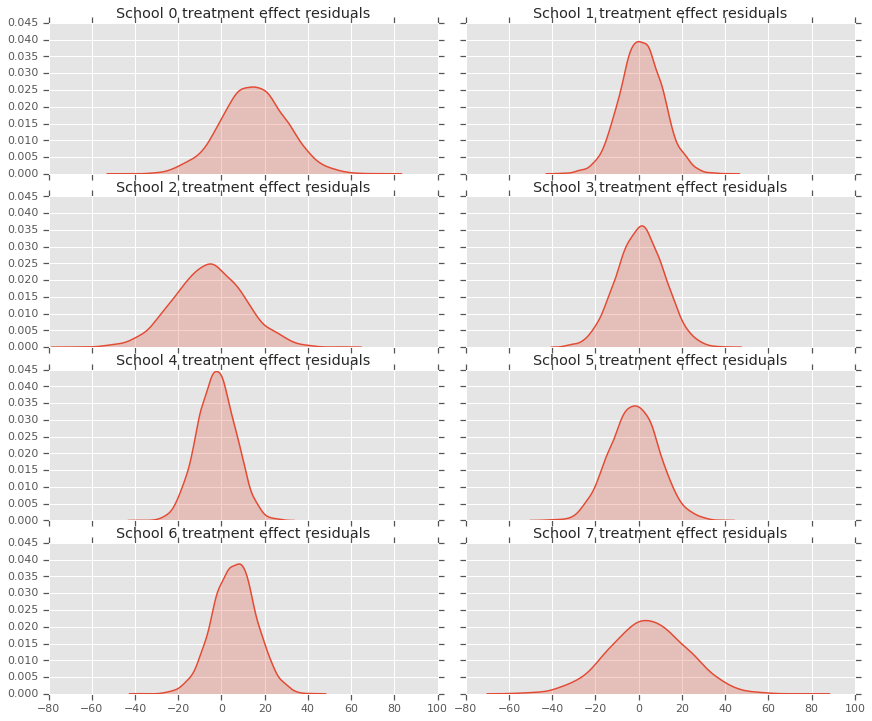

In [ ]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(residuals[:, 2*i].numpy(), ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect residuals".format(2*i))
  sns.kdeplot(residuals[:, 2*i + 1].numpy(), ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect residuals".format(2*i + 1))
plt.show()

# 감사의 말

이 튜토리얼은 원래 Edward 1.0([소스](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb))로 작성되었습니다. 해당 버전을 작성하고 수정하는데 기여해 주신 모든 분께 감사드립니다.

# 참고 문헌

1. Donald B. Rubin. Estimation in parallel randomized experiments. Journal of Educational Statistics, 6(4):377-401, 1981.
2. Andrew Gelman, John Carlin, Hal Stern, David Dunson, Aki Vehtari, and Donald Rubin. Bayesian Data Analysis, Third Edition. Chapman and Hall/CRC, 2013.